# Generate a top-n list of books on consumer preference - Amazon books data

**About Book Crossing Dataset**<br>

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0.

Reference: http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

**Objective**

This project entails building a Book Recommender System for users based on user-based and item-based collaborative filtering approaches.

#### Execute the below cell to load the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Loading data
books = pd.read_csv("gdrive/My Drive/AIML_RS_CSV/RS/books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('gdrive/My Drive/AIML_RS_CSV/RS/users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('gdrive/My Drive/AIML_RS_CSV/RS/ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### Check no.of records and features given in each dataset

In [ ]:
books.shape

(271360, 8)

In [ ]:
users.shape

(278858, 3)

In [ ]:
ratings.shape

(1149780, 3)

## Exploring books dataset

In [ ]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Drop last three columns containing image URLs which will not be required for analysis

In [ ]:
books = books.iloc[:,:5]

In [ ]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


**yearOfPublication**

### Check unique values of yearOfPublication


In [ ]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [ ]:
bookspub = books['yearOfPublication']

In [ ]:
bookspub.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

As it can be seen from above that there are some incorrect entries in this field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file.


Also some of the entries are strings and same years have been entered as numbers in some places. We will try to fix these things in the coming questions.

### Check the rows having 'DK Publishing Inc' as yearOfPublication

In [ ]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


### Drop the rows having `'DK Publishing Inc'` and `'Gallimard'` as `yearOfPublication`

In [ ]:
books = books[(books.yearOfPublication != 'DK Publishing Inc') & (books.yearOfPublication != 'Gallimard')]

### Change the datatype of yearOfPublication to 'int'

In [ ]:
books['yearOfPublication'] = books['yearOfPublication'].astype('int32')

In [ ]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication     int32
publisher            object
dtype: object

### Drop NaNs in `'publisher'` column


In [ ]:
#drop NaNs in 'publisher' column
books = books.dropna(subset=['publisher'])
books.publisher.isnull().sum()

0

## Exploring Users dataset

In [ ]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Get all unique values in ascending order for column `Age`

In [ ]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Age column has some invalid entries like nan, 0 and very high values like 100 and above

### Values below 5 and above 90 do not make much sense for our book rating case...hence replace these by NaNs

In [ ]:
import numpy as np

In [ ]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

### Replace null values in column `Age` with mean

In [ ]:
users['Age'] = users['Age'].fillna(users['Age'].mean())

### Change the datatype of `Age` to `int`

In [ ]:
users['Age'] = users['Age'].astype(int)

In [ ]:
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## Exploring the Ratings Dataset

### check the shape

In [ ]:
ratings.shape

(1149780, 3)

In [ ]:
n_users = users.shape[0]
n_books = books.shape[0]

In [ ]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Ratings dataset should have books only which exist in our books dataset. Drop the remaining rows

In [ ]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [ ]:
ratings_new.shape

(1031130, 3)

### Ratings dataset should have ratings from users which exist in users dataset. Drop the remaining rows

In [ ]:
ratings_new = ratings_new[ratings.userID.isin(users.userID)]

In [ ]:
ratings_new.shape

(1031130, 3)

### Consider only ratings from 1-10 and leave 0s in column `bookRating`

In [ ]:
ratings_new['bookRating'].unique()

array([ 0,  5,  3,  6,  7,  9,  8, 10,  1,  4,  2])

In [ ]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [ ]:
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031130, 3)
(383839, 3)
(647291, 3)


### Find out which rating has been given highest number of times

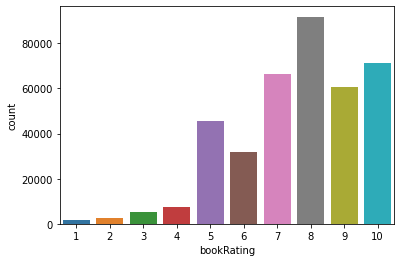

In [ ]:
#plotting count of bookRating
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

In [ ]:
#ratings_explicit['bookRating'].plot(kind = 'bar')

### **Collaborative Filtering Based Recommendation Systems**

### For more accurate results only consider users who have rated atleast 500 books

In [ ]:
counts1 = pd.value_counts(ratings_explicit['userID'])

In [ ]:
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 500].index)]

In [ ]:
ratings_explicit.head(2)

,userID,ISBN,bookRating
45339,11676,0001944711,6
45340,11676,0002005018,8


In [ ]:
ratings_explicit

,userID,ISBN,bookRating
45339,11676,0001944711,6
45340,11676,0002005018,8
45341,11676,0002118580,9
45342,11676,0002176432,5
45343,11676,0002184974,7
...,...,...,...
1040385,248718,1891400274,8
1040386,248718,1892123029,10
1040387,248718,1892881268,10
1040388,248718,2843231523,9


### Transform data to surprise format

In [ ]:
!pip install surprise

In [ ]:
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor


reader = Reader(rating_scale=(1, 10))

In [ ]:
ratings_explicit.head(2)

,userID,ISBN,bookRating
45339,11676,0001944711,6
45340,11676,0002005018,8


In [ ]:
ratings_explicit.shape

(29411, 3)

In [ ]:
data = Dataset.load_from_df(ratings_explicit[['userID', 'ISBN', 'bookRating']], reader)

In [ ]:
data.df.head(2)

,userID,ISBN,bookRating
45339,11676,0001944711,6
45340,11676,0002005018,8


### Points to Note:
1) Trainset is no longer a pandas dataframe. Rather, it's a specific datatypes defined by the Surprise library


2) UserID and ISBN in the pandas dataframe can contain any value (either string/integer etc). However, Trainset convert these raw ids into numeric indexes called as "inner id"


3) Methods are provided to convert rw id to inner id and vice verca

### SVD Based Recommendation System

In [ ]:
from surprise import Dataset,Reader

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_explicit[['userID', 'ISBN', 'bookRating']], reader)

In [ ]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

# to build on full data
#trainset = data.build_full_trainset()

In [ ]:
trainset.all_ratings()

<generator object Trainset.all_ratings at 0x7faa13288b48>

In [ ]:
# However the ids are the inner ids and not the raw ids
# raw ids can be obatined as follows

print(trainset.to_raw_uid(0))
#print(trainset.to_raw_iid(1066))

76499


In [ ]:
from surprise import SVD, KNNWithMeans
from surprise import accuracy

In [ ]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

In [ ]:
testset[0]

(153662, '006108185X', 9.0)

In [ ]:
test_pred = svd_model.test(testset)

In [ ]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 2.1998


2.199845849270215

## KNNWithMeans

In [ ]:
from surprise import KNNWithMeans
from surprise import accuracy

algo_i = KNNWithMeans(k=10, sim_options={ 'user_based': False})

algo_i.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
#from surprise.model_selection import cross_validate
#cross_validate(algo_i, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
test_pred=algo_i.test(testset)
print(accuracy.rmse(test_pred))

RMSE: 1.8790
1.8789856860600966


## KNNWithMeans gave better results.

We can try Cross validation and improve accuracy

In [ ]:
uid = str(11676)  # raw user id (as in the ratings file). They are **strings**!
iid = "074323748X"  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo_i.predict(uid, iid, r_ui=0.0, verbose=True)

user: 11676      item: 074323748X r_ui = 0.00   est = 7.73   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


### Generating top n recommendations

In [ ]:
pred = pd.DataFrame(test_pred)
pred[pred['uid'] == 11676][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(10)

,iid,r_ui,est
965,0525460543,10.0,6.950000
4485,0893753564,10.0,7.533333
4386,0590414291,10.0,8.400000
1137,0452262933,10.0,7.733249
1131,0373484232,10.0,9.400000
1126,0679457313,10.0,7.733249
4412,0743230655,10.0,7.733249
1111,0821776037,10.0,8.213333
4442,0394587952,10.0,7.733249
4443,0688108059,10.0,7.733249


Summarise your insights.

Model predicts average rating wherever estimation is not possible

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.